
## B站正剧：那年那兔那些事儿
* 1.结巴分词
    * 1.1 结巴分词原理
    * 1.2 结巴分词使用
* 2.文字处理
    * 2.1 去stopword
    * 2.2 整理词频
    * 2.3 关键词计算: TF-IDF，textrank
* 3.词云制作
* 4.沿时间动态变化: 高频词
    * 不同剧集的高频词
    * 不同剧集的弹幕分布
    * 24小时弹幕分布
    * 年内弹幕分布
    * 重要节日的表现

* 5.观众信息
    * 性别


In [10]:
#import requests
#from bs4 import BeautifulSoup as bs
import re
import time
#import lxml
import matplotlib.pyplot as plt
#from PIL import Image
from IPython.display import Image
import numpy as np
import seaborn as sns
%matplotlib inline

In [11]:
import jieba
import pandas as pd


## 结巴分词

** 结合基于规则和基于统计 **
1. 基于前缀词典实现高效的词图扫描，生成句子中汉字所有可能成词情况所构成的有向无环图 (DAG)
2. 采用动态规划查找最大概率路径, 找出基于词频的最大切分组合

跳进未名湖

** 1.根据离线统计词典查找到的词频与词性 **

|词语|频率|词性|
| ------------- |:-------------:| -----:|
|跳| 8462 |v
|进| 25668 |v
|跳进| 206 |v
|未名湖| 27 |ns
|未名| 6 |v
|未| 16803 |d
|名| 26255 |q
|湖| 12466 |ns

** 2. 构建有向无环图 **

 0: [0,1]
 
 1: [1]
 
 2: [2,3,4]
 
 3: [3]
 
 4: [4]

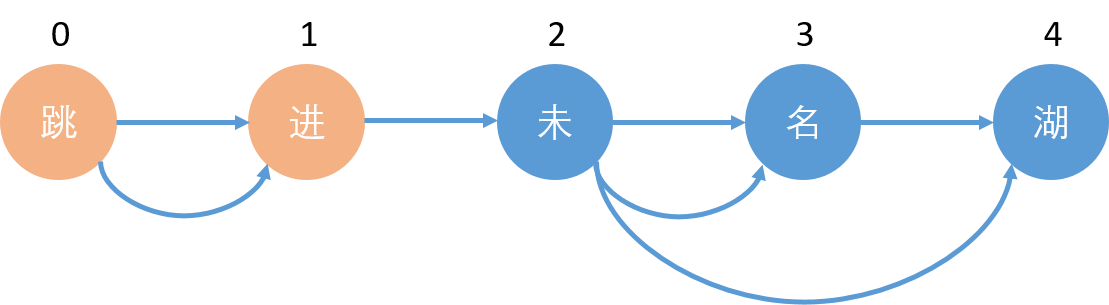

In [155]:
Image(filename='weiminghu.png')

** 3. 最大概率路径计算 **

1. 0 -> 1 -> 2 -> 3 -> 4     
   ** 跳/进/未/名/湖 **

2. 0,1 -> 2 -> 3 -> 4    
   **跳进/未/名/湖**
   
3. 0,1 -> 2,3 -> 4       
   **跳进/未名/湖**
   
4. 0,1 -> 2,3,4         
   **跳进/未名湖**


In [12]:
import jieba

In [13]:
fenci = jieba.cut("我在北京读大学，颐和园路的比五道口的要好",cut_all=False)
print("/ ".join(fenci))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.556 seconds.
Prefix dict has been built succesfully.


我/ 在/ 北京/ 读/ 大学/ ，/ 颐和园/ 路/ 的/ 比/ 五道口/ 的/ 要/ 好


* jieba.suggest_freq("我读的", tune=True)

In [14]:
jieba.suggest_freq("颐和园路",tune=True)

1

In [15]:
fenci = jieba.cut("我在北京读大学，颐和园路的比五道口的要好",cut_all=False)
print("/ ".join(fenci))

我/ 在/ 北京/ 读/ 大学/ ，/ 颐和园路/ 的/ 比/ 五道口/ 的/ 要/ 好


In [16]:
fenci = jieba.cut("我爱北京天安门，五环比六环多一环，学好python就不是低端劳动力了，呜呜",cut_all=False)
print("/ ".join(fenci))

我/ 爱/ 北京/ 天安门/ ，/ 五环/ 比六环/ 多/ 一环/ ，/ 学好/ python/ 就/ 不是/ 低端/ 劳动力/ 了/ ，/ 呜呜


* jieba.suggest_freq(("比","六环"), tune=True)

In [17]:
jieba.suggest_freq(("比","六环"),tune=True)

0

In [18]:
fenci = jieba.cut("我爱北京天安门，五环比六环少一环，学好python就不是低端劳动力了，呜呜",cut_all=False)
print("/ ".join(fenci))

我/ 爱/ 北京/ 天安门/ ，/ 五环/ 比/ 六/ 环/ 多/ 一环/ ，/ 学好/ python/ 就/ 不是/ 低端/ 劳动力/ 了/ ，/ 呜呜


In [21]:
jieba.suggest_freq('六环',tune=True)

2

In [22]:
fenci = jieba.cut("我爱北京天安门，五环比六环少一环，学好python就不是低端劳动力了，呜呜",cut_all=False)
print("/ ".join(fenci))

我/ 爱/ 北京/ 天安门/ ，/ 五环/ 比/ 六环/ 少一环/ ，/ 学好/ python/ 就/ 不是/ 低端/ 劳动力/ 了/ ，/ 呜呜


### 使用结巴进行分词
* 读取原始弹幕文件
* 数据清洗
    * 去除相同ID相同danmu相同时间
    * 去除NaN， dropNa
* 分词
* 去停用词
    * 加载停止词表
    * 去除停用词

* 读取原始弹幕文件

In [23]:
#danmu = pd.read_csv('../../../Danmu_files/番外篇第1集_current.csv',engine='python',encoding='utf-8')
danmu = pd.read_csv('../../data/第一季第1集.csv',engine='python',encoding='utf-8')


In [24]:
danmu.head(15)

,Unnamed: 0,time,format,font,color,data_unix,danmuchi,ID,rowID,danmu
0,0,330.961,1,25,16777215,1425561533,0,D1e724a3,823664980,周总理 生日快乐~~~
1,1,365.341,1,25,16777215,1425561535,0,D471d442,823665012,感动 泪目
2,2,325.836,1,25,15138834,1425561425,0,122b4249,823665613,周总理生日快乐
3,3,267.251,1,25,16777215,1425561559,0,4d64603e,823665751,种大蘑菇了。。。
4,4,358.314,1,25,16777215,1425561577,0,a018b2aa,823666293,好好听
5,5,2.291,1,25,16777215,1425561448,0,D2e676dc,823666337,周总理生日快乐
6,6,3.513,1,25,16777215,1425561588,0,250ea32a,823666635,我黄维恒不是个没种的男孩
7,7,242.078,1,25,16777215,1425561579,0,1b056ef2,823666714,矮马，我也好想去配音哦，还要人不
8,8,7.123,1,25,16777215,1425561596,0,250ea32a,823666875,我黄维恒不是个没种的男孩
9,9,353.754,1,25,16777215,1425561621,0,0f2fad7a,823667619,QAQ


In [5]:
danmu.head()

,Unnamed: 0,time,format,font,color,data_unix,danmuchi,ID,rowID,danmu
0,0,330.961,1,25,16777215,1425561533,0,D1e724a3,823664980,周总理 生日快乐~~~
1,1,365.341,1,25,16777215,1425561535,0,D471d442,823665012,感动 泪目
2,2,325.836,1,25,15138834,1425561425,0,122b4249,823665613,周总理生日快乐
3,3,267.251,1,25,16777215,1425561559,0,4d64603e,823665751,种大蘑菇了。。。
4,4,358.314,1,25,16777215,1425561577,0,a018b2aa,823666293,好好听


In [27]:
danmu.drop('Unnamed: 0',axis=1,inplace=True)

ValueError: labels ['Unnamed: 0'] not contained in axis

In [28]:
danmu.columns

Index(['time', 'format', 'font', 'color', 'data_unix', 'danmuchi', 'ID',
       'rowID', 'danmu'],
      dtype='object')

In [29]:
danmu[['ID','danmu']]

,ID,danmu
0,D1e724a3,周总理 生日快乐~~~
1,D471d442,感动 泪目
2,122b4249,周总理生日快乐
3,4d64603e,种大蘑菇了。。。
4,a018b2aa,好好听
5,D2e676dc,周总理生日快乐
6,250ea32a,我黄维恒不是个没种的男孩
7,1b056ef2,矮马，我也好想去配音哦，还要人不
8,250ea32a,我黄维恒不是个没种的男孩
9,0f2fad7a,QAQ


* 去除单人重复同样内容

* danmu_unique = danmu.drop_duplicates(['ID','danmu','data_unix']).reset_index()

In [30]:
danmu_unique = danmu.drop_duplicates(['ID','danmu','data_unix']).reset_index()

In [31]:
danmu_unique

,index,time,format,font,color,data_unix,danmuchi,ID,rowID,danmu
0,0,330.9610,1,25,16777215,1425561533,0,D1e724a3,823664980,周总理 生日快乐~~~
1,1,365.3410,1,25,16777215,1425561535,0,D471d442,823665012,感动 泪目
2,2,325.8360,1,25,15138834,1425561425,0,122b4249,823665613,周总理生日快乐
3,3,267.2510,1,25,16777215,1425561559,0,4d64603e,823665751,种大蘑菇了。。。
4,4,358.3140,1,25,16777215,1425561577,0,a018b2aa,823666293,好好听
5,5,2.2910,1,25,16777215,1425561448,0,D2e676dc,823666337,周总理生日快乐
6,6,3.5130,1,25,16777215,1425561588,0,250ea32a,823666635,我黄维恒不是个没种的男孩
7,7,242.0780,1,25,16777215,1425561579,0,1b056ef2,823666714,矮马，我也好想去配音哦，还要人不
8,8,7.1230,1,25,16777215,1425561596,0,250ea32a,823666875,我黄维恒不是个没种的男孩
9,9,353.7540,1,25,16777215,1425561621,0,0f2fad7a,823667619,QAQ


### 去除NaN

* danmu_unique.dropna(inplace=True)

In [45]:
danmu_unique.dropna(inplace=True)

### 分词

* comments = " ".join(list(danmu_unique['danmu']))

In [46]:
comments = " ".join(list(danmu_unique['danmu']))

* danmu_fenci = list(jieba.cut(comments.strip(),cut_all=False))

In [47]:
danmu_fenci = list(jieba.cut(comments.strip(),cut_all=False))

In [32]:
# jieba.suggest_freq("中国红", tune=True)
# jieba.suggest_freq("无路可退", tune=True)
# jieba.suggest_freq("带偏", tune=True)


2

In [48]:
len(danmu_fenci)

281416

In [49]:
danmu_fenci

['周总理',
 ' ',
 '生日快乐',
 '~',
 '~',
 '~',
 ' ',
 '感动',
 ' ',
 '泪目',
 ' ',
 '周总理',
 '生日快乐',
 ' ',
 '种大',
 '蘑菇',
 '了',
 '。',
 '。',
 '。',
 ' ',
 '好好',
 '听',
 ' ',
 '周总理',
 '生日快乐',
 ' ',
 '我',
 '黄维恒',
 '不是',
 '个',
 '没种',
 '的',
 '男孩',
 ' ',
 '矮马',
 '，',
 '我',
 '也好',
 '想',
 '去',
 '配音',
 '哦',
 '，',
 '还要',
 '人',
 '不',
 ' ',
 '我',
 '黄维恒',
 '不是',
 '个',
 '没种',
 '的',
 '男孩',
 ' ',
 'QAQ',
 ' ',
 '皇贞季',
 '哦哦哦',
 ' ',
 '我',
 '了',
 '个',
 '擦',
 ' ',
 '周总理',
 '生日快乐',
 '~',
 '~',
 '~',
 '~',
 '~',
 '~',
 '~',
 '~',
 '~',
 '~',
 '·',
 ' ',
 '还',
 '以为',
 '是',
 '蒋',
 '光头',
 '…',
 '…',
 ' ',
 '唉',
 '，',
 '当年',
 '不',
 '容易',
 '啊',
 '。',
 ' ',
 '麻',
 '蛇头',
 '上',
 '两个',
 '萝卜',
 '差评',
 ' ',
 '骂人',
 '都',
 '得',
 '举报',
 ' ',
 '恰恰',
 '是',
 '某些',
 '激动',
 '的',
 '人',
 '损害',
 '了',
 '兔',
 '吧',
 '声誉',
 ' ',
 'YY',
 '大国',
 ' ',
 '萌死',
 '了',
 ' ',
 '铁拳',
 '无敌',
 ' ',
 '周总理',
 '生日快乐',
 '！',
 ' ',
 '我',
 '黄维恒',
 '不是',
 '个',
 '没种',
 '的',
 '男孩',
 ' ',
 '周总理',
 '生日快乐',
 ' ',
 'duang',
 '~',
 ' ',
 '赞',
 '！',
 '！',
 '！',
 '！',
 '！'

### 去停用词


* 加载停用词词表


In [50]:
# './stopword_chinese.txt'
# 创建停用词list  
def create_stopwordslist(filepath):  
    stopwords = [line.strip() for line in open(filepath, 'r', encoding='utf8').readlines()]  
    return stopwords  

stopwords = create_stopwordslist('./stopword_chinese.txt')
#stopwords.pop(0)
stopwords.append(' ')

# \ufeff IS THE bom, byte order mark in python

In [47]:
print(stopwords)

['\ufeff', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '--', '.', '..', '...', '......', '...................', './', '.一', '.数', '.日', '/', '//', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '://', '::', ';', '<', '=', '>', '>>', '?', '@', 'A', 'Lex', '[', '\\', ']', '^', '_', '`', 'exp', 'sub', 'sup', '|', '}', '~', '~~~~', '·', '×', '×××', 'Δ', 'Ψ', 'γ', 'μ', 'φ', 'φ．', 'В', '—', '——', '———', '‘', '’', '’‘', '“', '”', '”，', '…', '……', '…………………………………………………③', '′∈', '′｜', '℃', 'Ⅲ', '↑', '→', '∈［', '∪φ∈', '≈', '①', '②', '②ｃ', '③', '③］', '④', '⑤', '⑥', '⑦', '⑧', '⑨', '⑩', '──', '■', '▲', '', '、', '。', '〈', '〉', '《', '》', '》），', '」', '『', '』', '【', '】', '〔', '〕', '〕〔', '㈧', '一', '一.', '一一', '一下', '一个', '一些', '一何', '一切', '一则', '一则通过', '一天', '一定', '一方面', '一旦', '一时', '一来', '一样', '一次', '一片', '一番', '一直', '一致', '一般', '一起', '一转眼', '一边', '一面', '七', '万一', '三', '三天两头', '三番两次', '三番五次', '上', '上下', '上升', '上去', '上来', '上述', '上面', '下', '下列', '下去', '下来', '下面', '不', '不一', '不

* 去停用词

In [51]:
refined_words = []
for word in danmu_fenci:
    if word not in stopwords:
        if word !='\t':
            refined_words.append(word)


In [52]:
refined_words

['周总理',
 '生日快乐',
 '感动',
 '泪目',
 '周总理',
 '生日快乐',
 '种大',
 '蘑菇',
 '好好',
 '听',
 '周总理',
 '生日快乐',
 '黄维恒',
 '没种',
 '男孩',
 '矮马',
 '想',
 '配音',
 '黄维恒',
 '没种',
 '男孩',
 'QAQ',
 '皇贞季',
 '哦哦哦',
 '擦',
 '周总理',
 '生日快乐',
 '蒋',
 '光头',
 '当年',
 '麻',
 '蛇头',
 '两个',
 '萝卜',
 '差评',
 '骂人',
 '举报',
 '激动',
 '损害',
 '兔',
 '声誉',
 'YY',
 '大国',
 '萌死',
 '铁拳',
 '无敌',
 '周总理',
 '生日快乐',
 '黄维恒',
 '没种',
 '男孩',
 '周总理',
 '生日快乐',
 'duang',
 '赞',
 '动画',
 '总理',
 '生日快乐',
 '北洋',
 '周总理',
 '生日快乐',
 '天',
 'TAT',
 '孙大炮',
 '蘑菇',
 '凸',
 '哭',
 'BGM',
 '追梦',
 '赤子心',
 '泪目',
 '555555',
 'BGM',
 '追梦',
 '赤子心',
 '周总理',
 '生快',
 '两个',
 '星期',
 '发布',
 '一集',
 '周总理',
 '生日快乐',
 '我来',
 '催',
 '总理',
 '国家',
 '跌跌撞撞',
 '歼敌',
 '一亿',
 '虎踞',
 '台湾',
 '周总理',
 '生日快乐',
 '祖国',
 '万岁',
 '23333',
 '周总理',
 '生日快乐',
 '祖国',
 '万岁',
 '祖国',
 '万岁',
 '高卢',
 '鸡',
 '左边',
 '汉斯',
 '猫',
 '祖国',
 '万岁',
 '祖国',
 '万岁',
 '结尾曲',
 '犯规',
 '呜呜',
 '总理',
 '555',
 '总理',
 '祖国',
 '万岁',
 '祖国',
 '万岁',
 '游击战',
 '配音',
 '好受',
 '哭',
 '硬币',
 '走',
 '小胡子',
 '23',
 '米粒',
 '坚是',
 '白头',
 '鹰',
 '鹰',
 '酱',
 '二周目

### 整理词频

In [53]:
from collections import Counter
c = Counter(refined_words)

In [54]:
c

Counter({'周总理': 115,
         '生日快乐': 213,
         '感动': 1381,
         '泪目': 1320,
         '种大': 1,
         '蘑菇': 191,
         '好好': 44,
         '听': 127,
         '黄维恒': 6,
         '没种': 5,
         '男孩': 34,
         '矮马': 1,
         '想': 563,
         '配音': 162,
         'QAQ': 654,
         '皇贞季': 11,
         '哦哦哦': 9,
         '擦': 68,
         '蒋': 283,
         '光头': 164,
         '当年': 64,
         '麻': 10,
         '蛇头': 1,
         '两个': 37,
         '萝卜': 2,
         '差评': 7,
         '骂人': 2,
         '举报': 10,
         '激动': 39,
         '损害': 1,
         '兔': 403,
         '声誉': 1,
         'YY': 1,
         '大国': 106,
         '萌死': 13,
         '铁拳': 20,
         '无敌': 31,
         'duang': 7,
         '赞': 96,
         '动画': 192,
         '总理': 89,
         '北洋': 4,
         '天': 100,
         'TAT': 31,
         '孙大炮': 46,
         '凸': 32,
         '哭': 2385,
         'BGM': 231,
         '追梦': 401,
         '赤子心': 401,
         '555555': 4,
         '生快': 1

#### sort by key

In [55]:

sorted_c_key = sorted(c.items(),key=lambda t:t[0])
sorted_c_key

[('++', 2),
 ('+++++', 1),
 ('++++++++++++', 1),
 ('+_+', 1),
 ('....', 53),
 ('.....', 32),
 ('.......', 10),
 ('........', 11),
 ('.........', 6),
 ('..........', 3),
 ('...........', 6),
 ('............', 3),
 ('.............', 3),
 ('..............', 1),
 ('....................', 1),
 ('..........................', 1),
 ('....................................', 1),
 ('0.0', 12),
 ('00', 2),
 ('01', 10),
 ('02', 6),
 ('04', 2),
 ('05', 5),
 ('06', 2),
 ('07', 2),
 ('0712', 1),
 ('08', 2),
 ('09', 4),
 ('0919', 1),
 ('1.1', 1),
 ('1.18', 1),
 ('1.25', 4),
 ('1.5', 5),
 ('10', 31),
 ('10.1', 8),
 ('10.10', 1),
 ('10.2', 3),
 ('10.4', 1),
 ('100', 5),
 ('100%', 1),
 ('1000', 2),
 ('1001', 12),
 ('10086', 3),
 ('100M', 1),
 ('100W', 1),
 ('100w', 1),
 ('1031531020.0', 1),
 ('1043', 1),
 ('105', 1),
 ('1080', 1),
 ('1080p', 1),
 ('11', 10),
 ('111', 3),
 ('1111', 1),
 ('11111', 1),
 ('117', 2),
 ('12', 26),
 ('120', 1),
 ('121', 2),
 ('122', 1),
 ('12312.0', 1),
 ('12345', 1),
 ('1234567'

#### sort by value

In [56]:
sorted_c_value = sorted(c.items(),key=lambda t:t[1],reverse=True)
sorted_c_value

[('中国', 2883),
 ('哭', 2385),
 ('家', 1620),
 ('种花', 1593),
 ('兔子', 1486),
 ('感动', 1381),
 ('泪目', 1320),
 ('中华', 1055),
 ('日本', 923),
 ('万岁', 816),
 ('此生', 761),
 ('历史', 707),
 ('无悔', 683),
 ('鸡', 673),
 ('美国', 662),
 ('骄傲', 655),
 ('QAQ', 654),
 ('红', 588),
 ('哈哈哈', 575),
 ('想', 563),
 ('国共合作', 554),
 ('第二次', 510),
 ('原子弹', 505),
 ('华夏', 465),
 ('卧槽', 439),
 ('说', 438),
 ('这是', 432),
 ('国共', 432),
 ('山新', 425),
 ('兔', 403),
 ('脚盆', 403),
 ('追梦', 401),
 ('赤子心', 401),
 ('入', 401),
 ('莫名', 398),
 ('祖国', 390),
 ('爱', 367),
 ('秃子', 364),
 ('日俄战争', 354),
 ('零式', 352),
 ('孙中山', 347),
 ('内战', 346),
 ('合作', 336),
 ('好萌', 335),
 ('第一次', 333),
 ('真的', 328),
 ('来世', 327),
 ('国父', 319),
 ('弹幕', 314),
 ('麻蛇', 313),
 ('游击战', 308),
 ('毛', 308),
 ('年', 296),
 ('死', 292),
 ('迷', 287),
 ('蒋介石', 286),
 ('自豪', 285),
 ('蒋', 283),
 ('bgm', 282),
 ('23333', 281),
 ('胡子', 278),
 ('2333', 277),
 ('哈哈哈哈', 265),
 ('蜜汁', 256),
 ('抗日', 255),
 ('笑', 254),
 ('中华人民共和国', 251),
 ('零号', 246),
 ('开国大典', 245),
 ('做', 242),


### 关键词计算
* TF-IDF
* textrank

提取关键词

In [30]:
from jieba import analyse

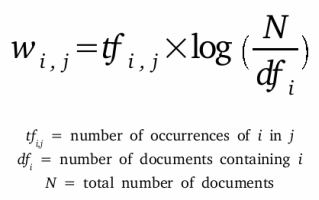

In [28]:
Image(filename='./tfidf.png')

* tags_tfidf = analyse.extract_tags(comments,topK=20)

In [33]:
tags_tfidf

['种花',
 '泪目',
 '兔子',
 '感动',
 '中国',
 'QAQ',
 '中华',
 '无悔',
 '此生',
 '卧槽',
 '万岁',
 '哈哈哈',
 '骄傲',
 '山新',
 '国共合作',
 '追梦',
 '赤子心',
 '日本',
 '脚盆',
 '原子弹']

#### textrank算法进行关键词提取

** 算法 **
1. 识别文本单词，将其作为图的顶点置入图中
2. 一一计算文本单词对的关系（权重），并用这样的权重构造出图中对应的边
3. 基于textrank迭代计算公式，计算每个顶点（单词）的权重，直至收敛
4. 按照顶点的分数降序排列

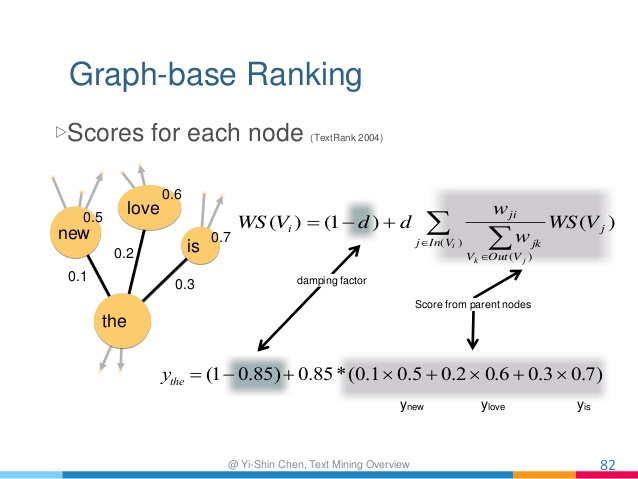

In [34]:
Image(filename='./textranking_form.jpg')

* textrank = analyse.textrank
* tags_textrank = textrank(comments,topK=20,withWeight=True,allowPOS=('ns','n','vn','v'))

In [36]:
for tag in tags_textrank:
    print(tag[0],tag[1])

中国 1.0
兔子 0.6543484024907827
日本 0.589959461302944
种花 0.5735364783951884
泪目 0.540673433894164
感动 0.5328108862158478
美国 0.40472053302915856
历史 0.36336806341075634
无悔 0.2935500464513619
没有 0.28886894601987323
原子弹 0.26822995976973074
国共合作 0.22423823813983326
华夏 0.21212883820853604
零式 0.2012112402074941
追梦 0.19747559303175255
来世 0.19668340102772777
赤子心 0.19549976161240093
卧槽 0.19193272344054976
莫名 0.1846880722686546
秃子 0.17930892936507875


### 生成词云

* 下载相应版本的wordcloud: https://www.lfd.uci.edu/~gohlke/pythonlibs/#wordcloud
* pip install 

In [2]:
from wordcloud import WordCloud

In [3]:
refined_words=['A','B','C','A']

In [7]:
# use words stored in refined_words
words_space_split = " ".join(refined_words)
words_space_split

'A B C A'

In [9]:
Bilibili_wordcloud = WordCloud(collocations=False,\
font_path=r"C:\Windows\Fonts\微软雅黑.ttf",width=2300,\
height=2000,max_words=2000).generate(words_space_split) # 生成词云

plt.imshow(Bilibili_wordcloud)
plt.axis("off")
plt.show()
#Bilibili_wordcloud.to_file('种花.png')# 保存

ValueError: We need at least 1 word to plot a word cloud, got 0.

In [70]:
twitter_mask = np.array(Image.open('Test.jpg'))

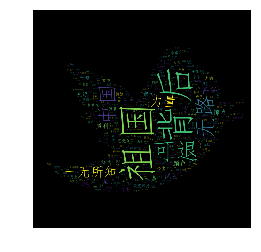

In [78]:
Bilibili_wordcloud = WordCloud(collocations=False,\
font_path=r"C:\Windows\Fonts\微软雅黑.ttf",width=1300,\
height=1000,max_words=500,mask=twitter_mask,background_color='black').generate(words_space_split) # 生成词云

plt.imshow(Bilibili_wordcloud)
plt.axis("off")
plt.show()
Bilibili_wordcloud.to_file('无路可退.png')# 保存

In [42]:
import gc
gc.collect()

29

## 4. 沿时间的动态变化: 频率与高频词
* 不同剧集的高频词
* 不同剧集的弹幕分布
* 24小时弹幕分布
* 年内弹幕分布
* 重要节日的表现

* 不同剧集的高频词

In [38]:
# filenames = []
# for i in range(12):
#     name = '../../../Danmu_files/第一季第'+str(int(i+1))+'集.csv'
#     filenames.append(name)

In [55]:
def rm_stop(danmu_fenci,stopwords):
    refined_words = []
    for word in danmu_fenci:
        if word not in stopwords:
            if word !='\t':
                refined_words.append(word)
    return refined_words

# './stopword_chinese.txt'
# 创建停用词list  
def create_stopwordslist(filepath):  
    stopwords = [line.strip() for line in open(filepath, 'r', encoding='utf8').readlines()]  
    return stopwords  

stopwords = create_stopwordslist('./stopword_chinese.txt')
#stopwords.pop(0)
stopwords.append(' ')

In [64]:
# HF_content = {}

# for i in range(12):
#     danmu = pd.read_csv(filenames[i],engine='python',encoding='utf-8')
#     danmu.dropna(inplace=True)
#     danmu.drop('Unnamed: 0',axis=1,inplace=True)
#     danmu_unique = danmu.drop_duplicates(['ID','danmu','data_unix']).reset_index()
#     comments = " ".join(list(danmu_unique['danmu']))
#     danmu_fenci = list(jieba.cut(comments.strip(),cut_all=False))
#     refined_words = rm_stop(danmu_fenci,stopwords)
#     tags_tfidf = analyse.extract_tags(" ".join(refined_words),topK=20)
#     HF_content[i+1]=tags_tfidf
    

In [66]:
# HF_content_df = pd.DataFrame(HF_content)
# HF_content_df.head()

,1,2,3,4,5,6,7,8,9,10,11,12
0,种花,骗子,致敬,回家,兔子,如你所愿,谢谢,谢谢,致敬,中巴,中巴,感激
1,泪目,回来,种花,忠骨,大国,盛世,我学,暂停,礼炮,兔子,友谊,种花
2,兔子,君临天下,此生,马革裹尸,一只,男神,QAQ,成功,献上,友谊,万岁,幸福
3,感动,雄赳赳,敬礼,公辞,致敬,蘑菇,兔子,致敬,中华,万岁,感激,这碗
4,中国,有生之年,无悔,青山,钱学森,周总理,大哥,算盘,崛起,中多,粤语,有生之年


In [68]:
#HF_content_df.to_csv('HF_content.csv',encoding='utf-8')

* 不同剧集的弹幕分布

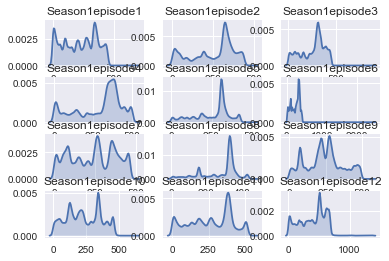

In [105]:
f, axs = plt.subplots(4,3,figsize=(13,11))
for i in range(12):
    danmu = pd.read_csv(filenames[i],engine='python',encoding='utf-8')
    danmu.dropna(inplace=True)
    time_danmu = danmu['time']
    sns.kdeplot(np.array(list(time_danmu)), shade=True,ax=axs[i//3][i%3])
    axs[i//3][i%3].set_title('Season'+str(1)+'episode'+str(i+1))

2

In [9]:
f, axs = plt.subplots(4,3,figsize=(13,11))
for i in range(12):
    danmu = pd.read_csv(filenames[i],engine='python',encoding='utf-8')
    danmu.dropna(inplace=True)
    date_danmu = danmu['data_unix']
    date_array = np.array(date_time) + 8*60*60
    all_time_array = date_array/(24*60*60)
    sns.kdeplot(all_time_array), shade=True,ax=axs[i//3][i%3])
    axs[i//3][i%3].set_title('Season'+str(1)+'episode'+str(i+1))

SyntaxError: invalid syntax (<ipython-input-9-6a7745ecb60d>, line 8)

### 24小时的弹幕频率分布

* unix time: 1970-01-01 00:00:00 Coordinated Universal Time (UTC)
* unix time: 1970-01-01 08:00:00 Beijing Time
* in seconds

In [54]:
Danmu_season_df = pd.DataFrame()
for i in range(12):
    danmu = pd.read_csv(filenames[i],engine='python',encoding='utf-8')
    danmu.dropna()
    danmu.drop('Unnamed: 0',axis=1,inplace=True)
    danmu_unique = danmu.drop_duplicates(['ID','danmu','data_unix']).reset_index()
    Danmu_season_df = Danmu_season_df.append(danmu,ignore_index=True)


In [51]:
Danmu_season_df.append(danmu,ignore_index=True)

,time,format,font,color,data_unix,danmuchi,ID,rowID,danmu
0,186.266,1,25,16777215,1438871517,0,f505d4a0,1074217887,23333333
1,187.038,1,25,16777215,1438871521,0,f505d4a0,1074218181,╭(°A°`)╮
2,525.284,1,25,16777215,1438871528,0,0d2111dd,1074218759,幸福并感激着
3,546.454,1,25,16777215,1438871529,0,D644b51f,1074218845,生而为王
4,276.350,1,25,16777215,1438871532,0,D1e9f7fb,1074219095,炮击金门，推荐百度下，特好玩的历史
5,539.027,1,25,16777215,1438871539,0,e3cddb89,1074219667,谢谢！谢谢！谢谢！！！
6,536.169,1,25,16711680,1438871540,0,6ee49a4e,1074219743,幸福并感激着
7,209.513,1,25,16777215,1438871553,0,04762e78,1074220747,23333333333333
8,490.007,1,25,16777215,1438871553,0,cd917bf6,1074220785,估计没有第二季了 T-T
9,146.999,1,25,16777215,1438871555,0,D215a6e9,1074220887,搞他！


* process date time

In [114]:
all_time = Danmu_season_df['data_unix']
all_time_array = np.array(all_time) + 8*60*60


In [118]:
all_time_array_24 = all_time_array%(24*60*60)/(60*60)

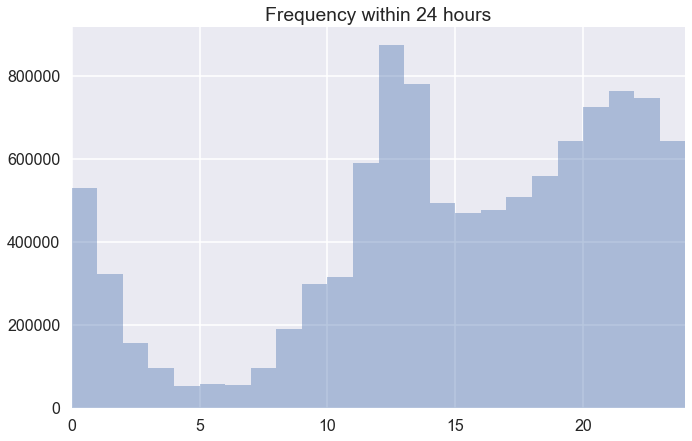

In [126]:
plt.figure(figsize=(11,7))
sns.distplot(all_time_array_24,bins=24,kde=False).set_title('Frequency within 24 hours')
sns.plt.xlim(0, 24)
sns.set_context("poster",font_scale=1.5)


### 年内的弹幕频率分布

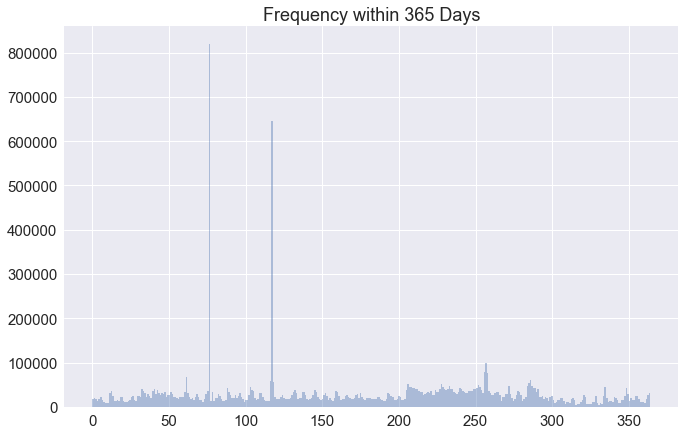

In [135]:
plt.figure(figsize=(11,7))
all_time = Danmu_season_df['data_unix']
all_time_array = np.array(all_time) + 8*60*60
all_time_array_365 = np.floor(all_time_array%(24*60*60*365)/(24*60*60))
sns.distplot(all_time_array_365,bins=365,kde=False).set_title('Frequency within 365 Days')
sns.set_context("notebook",font_scale=1.5)

In [137]:
from collections import Counter
C_d = Counter(all_time_array_365)

In [140]:
for day, counts in C_d.items():
    if counts > 90000:
        print(day)

76.0
117.0
257.0


## 5. 观众信息
* merge
* 性别

In [2]:
#Danmu_season_df
import pandas as pd

In [3]:
user_info = pd.read_csv('ids_pd235.csv')

In [4]:
user_info.head()

,Unnamed: 0,ID,orig_ID
0,0,1f7dd51a,8976061.0
1,1,cc108eca,87371356.0
2,2,83eff729,8961841.0
3,3,41870812,210120754.0
4,4,fb64cc6d,6802440.0


In [5]:
user_gender = pd.DataFrame(user_info['orig_ID'])

In [6]:
user_gender['gender']=pd.Series('a',index=range(user_info.shape[0]))


In [7]:
user_gender.head()

,orig_ID,gender
0,8976061.0,a
1,87371356.0,a
2,8961841.0,a
3,210120754.0,a
4,6802440.0,a


In [ ]:
import random
for i in range(user_gender.shape[0]):
    if random.random()<0.298:
        user_gender[i,'gender']='Female'
    else:
        user_gender[i,'gender']='Male'
    

In [ ]:
user_info.merge(user_gender, left_on='orig_ID', right_on='orig_ID', how='inner')
Danmu_season_df.merge(user_info,left_on='ID',right_on='ID',how='inner')

* 脑筋急转弯